In [79]:
# Import library yang kalian butuhkan
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

In [80]:
def resize_image(image, target_size):

    original_height, original_width, _ = image.shape
    target_width, target_height = target_size
    resized_image = np.zeros((target_height, target_width, 3), dtype=np.uint8)
    
    for i in range(target_height):
        for j in range(target_width):
            original_x = int(j * original_width / target_width)
            original_y = int(i * original_height / target_height)
            resized_image[i, j] = image[original_y, original_x]
    
    return resized_image

In [81]:
def insertGambar(folder):
    data = []
    filenames = []
    datalabel = [] 
    path = []
    data_distribution = {}
    for label in (os.listdir(folder)):
        images = os.listdir(folder+label)
        data_distribution[label] = len(images)
        datalabel.append(label)
        print(label)
        count = 0
        for filename in tqdm(os.listdir(folder+label)):
            if count == 100:
                break
            else :
                count += 1
            img = cv.imread(os.path.join(folder+label,filename))
            if img is not None:
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img = resize_image(img, (256, 256))
                filenames.append(filename)
                path.append(label)
                data.append(img)
    return data, filenames, datalabel, path , data_distribution

In [82]:
images, filenames, labels, path, distribusi = insertGambar("dataset/")

print("Jumlah gambar:", len(images))
print("Jumlah label unik:", len(labels))
print("Jumlah nama file:", len(filenames))
print("Distribusi data:", distribusi)


Acne vulgaris


100%|██████████| 100/100 [00:04<00:00, 22.48it/s]


Rosacea


100%|██████████| 100/100 [00:04<00:00, 22.16it/s]

Jumlah gambar: 200
Jumlah label unik: 2
Jumlah nama file: 200
Distribusi data: {'Acne vulgaris': 100, 'Rosacea': 100}


In [83]:
def display_sample(images):
  plt.figure(figsize=(20,10))
  for i in range(7):
    plt.subplot(1,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap='gray')
  plt.show()    

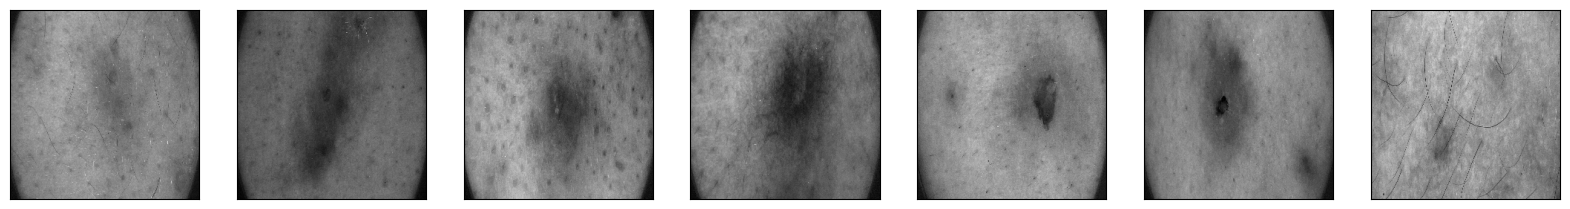

In [84]:
def gray_scaling(data):
    grayData = []
    for img in data:
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        grayData.append(gray)
    return grayData

gray_img = gray_scaling(images)

display_sample(gray_img)

In [85]:
def median(img):
    height, width = img.shape
    kernel = np.zeros((3, 3), np.float32) / 9
    hasilMedian = np.zeros((height, width), dtype=np.uint8)
    for i in range(kernel.shape[0]//2, height-kernel.shape[0]//2):
        for j in range(kernel.shape[0]//2, width-kernel.shape[0]//2):
            temp = []
            for k in range(-kernel.shape[0]//2, kernel.shape[0]//2+1):
                for l in range(-kernel.shape[0]//2, kernel.shape[0]//2+1):
                    temp.append(img[i+k][j+l])
            temp.sort()
            median = temp[kernel.shape[0]**2//2]
            if kernel.shape[0]**2 % 2 == 0:
                median = (temp[kernel.shape[0]**2//2 - 1] + temp[kernel.shape[0]**2//2]) // 2
            else:
                median = temp[kernel.shape[0]**2//2]
            hasilMedian[i][j] = median

    return hasilMedian

def medianFilterData(data):
    hasil = []
    for img in tqdm(data):
        gambar = median(img)
        hasil.append(gambar)
    return hasil

100%|██████████| 200/200 [00:46<00:00,  4.32it/s]


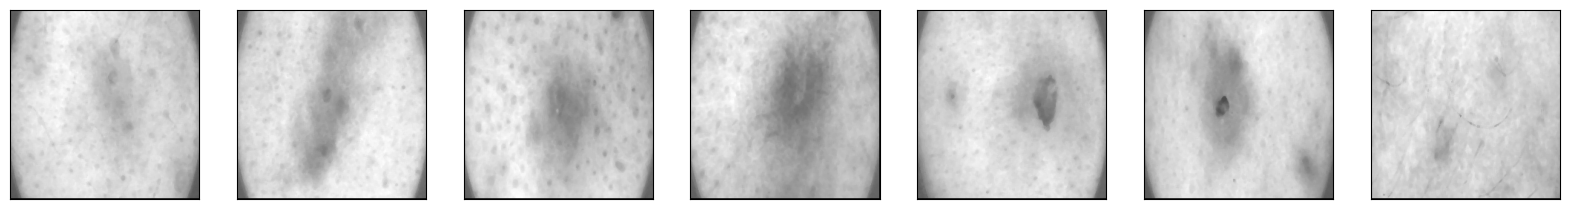

In [86]:
medianData = medianFilterData(gray_img)

display_sample(medianData)

In [87]:
def getPad(image, kernel):
    i = (kernel.shape[1]-1)//2
    j = (kernel.shape[0]-1)//2

    kiri = i
    kanan = (kernel.shape[1]-1)-i
    atas = j
    bawah = (kernel.shape[0]-1)-j
    result = np.pad(image,((atas, bawah), (kiri,kanan)), 'edge')

    return result

prewittX = np.array([
    [-1,0,1],
    [-1,0,1],
    [-1,0,1]
])

prewittY = np.array([
    [1,1,1],
    [0,0,0],
    [-1,-1,-1]
])

def findEdge(image, kernelx, kernely):
    result = np.zeros(image.shape, dtype=float)
    pad = getPad(image, kernelx)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            x = 0
            y = 0
            for k in range(kernelx.shape[0]):
                for l in range(kernelx.shape[1]):
                    x += pad[i+k][j+l] * kernelx[k,l]
                    y += pad[i+k][j+l] * kernely[k,l]
            result[i,j] = np.sqrt(x*x + y*y)
    return result

def prewittFilterData(data):
    hasil = []
    for img in tqdm(data):
        gambar = findEdge(img, prewittX, prewittY)
        hasil.append(gambar)
    return hasil

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [01:20<00:00,  2.48it/s]


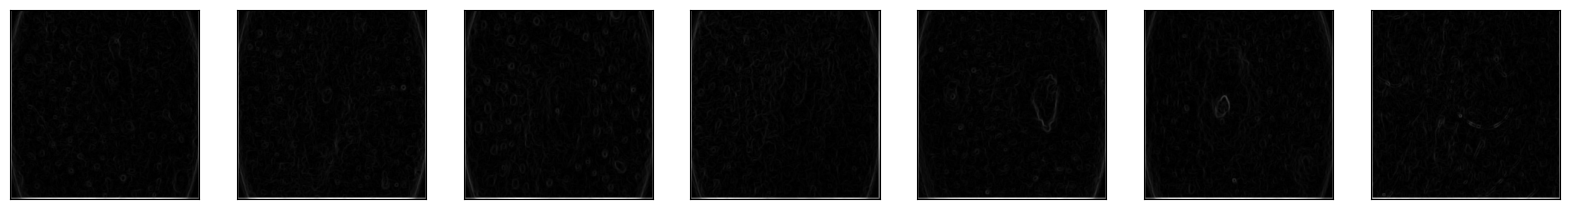

In [88]:
prewittData = prewittFilterData(medianData)
display_sample(prewittData)

In [89]:
def threshold(gambar):
    ambang = 10
    hasilThreshold = np.where(gambar >= ambang, 128, 255)
    return hasilThreshold

def thresholdFilterData(data):
    hasil = []
    for img in tqdm(data):
        gambar = threshold(img)
        hasil.append(gambar)
    return hasil

100%|██████████| 200/200 [00:00<00:00, 781.77it/s]


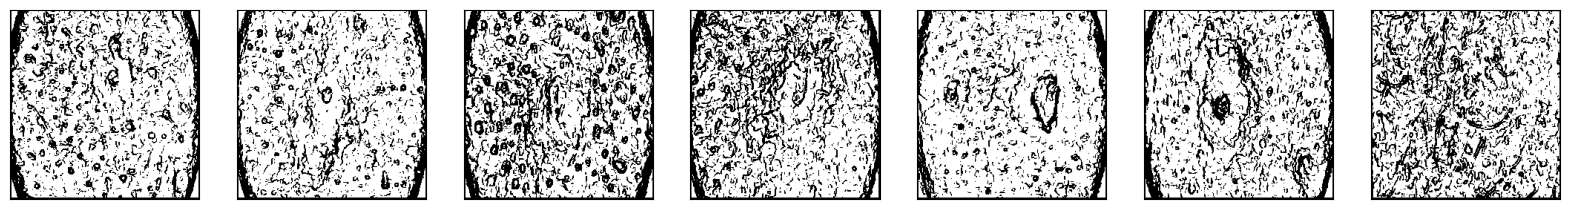

In [90]:
thresholdData = thresholdFilterData(prewittData)
display_sample(thresholdData)

In [91]:
def dilasi(citra, mask):
    tinggiPad, lebarPad = mask.shape[0] // 2, mask.shape[1] // 2
    citraPad = np.pad(citra, ((tinggiPad, tinggiPad), (lebarPad, lebarPad)), mode='constant', constant_values=0)
    output = np.zeros(citra.shape, dtype=np.uint8)

    for baris in range(tinggiPad, citraPad.shape[0] - tinggiPad):
        for kolom in range(lebarPad, citraPad.shape[1] - lebarPad):
            area = citraPad[baris - tinggiPad:baris + tinggiPad + 1, kolom - lebarPad:kolom + lebarPad + 1]
            if np.any(area[mask == 1] == 255):
                output[baris - tinggiPad, kolom - lebarPad] = 255

    return output

def erosi(citra, mask):
    padT, padL = mask.shape[0] // 2, mask.shape[1] // 2
    citraPad = np.pad(citra, ((padT, padT), (padL, padL)), mode='constant', constant_values=255)
    hasil = np.zeros_like(citra, dtype=np.uint8)

    for r in range(padT, citraPad.shape[0] - padT):
        for c in range(padL, citraPad.shape[1] - padL):
            blok = citraPad[r - padT:r + padT + 1, c - padL:c + padL + 1]
            if np.all(blok[mask == 1] == 255):
                hasil[r - padT, c - padL] = 255

    return hasil

def opening(citra, mask):
    erosiHasil = erosi(citra, mask)
    openingHasil = dilasi(erosiHasil, mask)
    return openingHasil

kernel = np.array([[0, 0, 1, 1, 1],
                   [0, 0, 1, 1, 1],
                   [1, 1, 1, 1, 1],
                   [1, 1, 1, 0, 0],
                   [1, 1, 1, 0, 0]])

def openingFilterData(data):
    hasil = []
    for img in tqdm(data):
        gambar = opening(img, kernel)
        hasil.append(gambar)
    return hasil


100%|██████████| 200/200 [01:31<00:00,  2.19it/s]


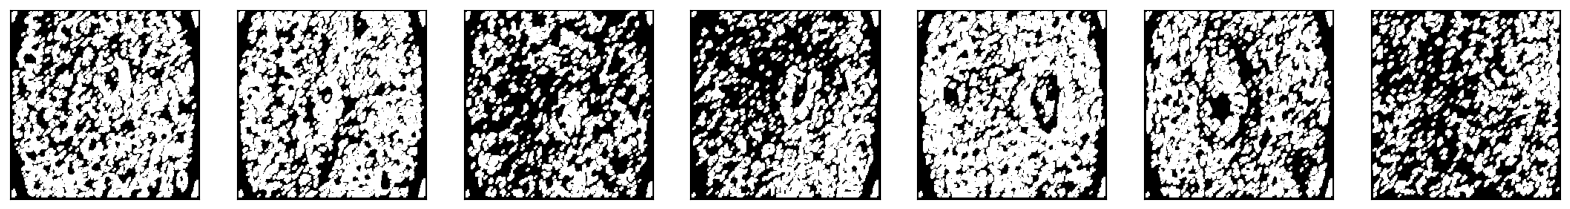

In [92]:
openingData = openingFilterData(thresholdData)
display_sample(openingData)

In [93]:
def normalize_image(image, skala_min=0, skala_max=255):
    tinggi, lebar = image.shape
    hasil = np.zeros((tinggi, lebar))
    min_val = np.min(image)
    max_val = np.max(image)
    for i in range(tinggi):
        for j in range(lebar):
            hasil[i, j] = (image[i, j] - min_val) * (skala_max - skala_min) / (max_val - min_val) + skala_min
    return hasil

def normalizeFilterData(data):
    hasil = []
    for img in tqdm(data):
        gambar = normalize_image(img)
        hasil.append(gambar)
    return hasil

  0%|          | 0/200 [00:00<?, ?it/s]C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14020\1633027307.py:8: RuntimeWarning: overflow encountered in scalar multiply
  hasil[i, j] = (image[i, j] - min_val) * (skala_max - skala_min) / (max_val - min_val) + skala_min
100%|██████████| 200/200 [00:06<00:00, 30.33it/s]


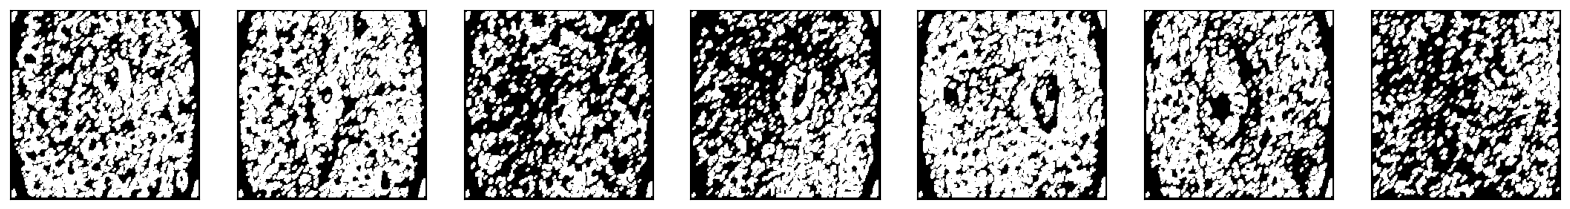

In [94]:
normalizeData = normalizeFilterData(openingData)
display_sample(normalizeData)